In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cvxopt import matrix, solvers

In [3]:
Q = np.array([[0, 0, 0],
             [0, 1, 0],
             [0, 0, 1]], dtype=float)

P = np.zeros(3)

A = np.array([[-1., 0, 0],
             [-1, -2, -2],
             [1, 2, 0],
             [1, 3, 0.]])

c = np.ones(4)

In [4]:
args = [matrix(Q), matrix(P), matrix(-A), matrix(-c)]

In [5]:
result = solvers.qp(*args)

     pcost       dcost       gap    pres   dres
 0:  3.2653e-01  1.9592e+00  6e+00  2e+00  4e+00
 1:  1.5796e+00  8.5663e-01  7e-01  2e-16  2e-15
 2:  1.0195e+00  9.9227e-01  3e-02  2e-16  6e-16
 3:  1.0002e+00  9.9992e-01  3e-04  1e-16  2e-15
 4:  1.0000e+00  1.0000e+00  3e-06  2e-16  2e-15
 5:  1.0000e+00  1.0000e+00  3e-08  0e+00  1e-15
Optimal solution found.


In [6]:
w = np.array(result['x'])
w

array([[-1.00000001],
       [ 1.00000001],
       [-1.00000001]])

In [7]:
np.dot(A, w)

array([[ 1.00000001],
       [ 1.00000002],
       [ 1.        ],
       [ 2.00000001]])

In [8]:
X = np.array([[0, 0], [2, 2], [2, 0.], [3, 0.]])
y = np.array([-1., -1, 1, 1])


In [9]:
Q = np.dot(y[:, np.newaxis]*X, X.T*y[np.newaxis, :])
Q

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  8., -4., -6.],
       [ 0., -4.,  4.,  6.],
       [ 0., -6.,  6.,  9.]])

In [10]:
A = np.vstack((y, -y, np.identity(len(y))))
A

array([[-1., -1.,  1.,  1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [11]:
p = -np.ones(len(y))
c = np.zeros(len(A))

In [12]:
result = solvers.qp(*map(matrix, [Q, p, -A, c]))

     pcost       dcost       gap    pres   dres
 0: -1.0249e+00 -2.3063e+00  1e+01  3e+00  2e+00
 1: -8.2851e-01 -1.7889e+00  1e+00  1e-01  6e-02
 2: -9.8330e-01 -1.0720e+00  1e-01  4e-03  2e-03
 3: -9.9979e-01 -1.0008e+00  1e-03  4e-05  2e-05
 4: -1.0000e+00 -1.0000e+00  1e-05  4e-07  2e-07
 5: -1.0000e+00 -1.0000e+00  1e-07  4e-09  2e-09
Optimal solution found.


In [13]:
coef = np.array(result['x'])
coef

array([[  5.00000005e-01],
       [  5.00000022e-01],
       [  1.00000000e+00],
       [  2.20495928e-08]])

In [14]:
w = np.dot(y*coef.ravel(), X)
w

array([ 1.00000003, -1.00000004])

In [15]:
y - np.dot(X, w)

array([-1.        , -0.99999997, -1.00000006, -2.00000009])

### Validation [ex.1-ex.5]

In [30]:
from sklearn.linear_model import LinearRegression

In [16]:
data_in = np.loadtxt('in.dta')
data_out = np.loadtxt('out.dta')

In [26]:
X_in = data_in[:, :-1]
y_in = data_in[:, -1]

X_out = data_out[:, :-1]
y_out = data_out[:, -1]

(-1.0590629633243727,
 1.1091193133243729,
 -0.94462697244150096,
 0.99745059244150114)

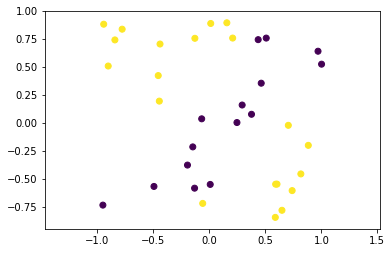

In [27]:
plt.scatter(X_in[:, 0], X_in[:, 1], c=y_in)
plt.axis('equal')

In [20]:
def transfrom_X(X):
    '''transform vector from [x1, x2] 
    to [1, x1, x2, x1**2, x2**2, x1*x2, |x1-x2|, |x1+x2|]'''
    x1, x2 = X.T
    return np.c_[np.ones(len(X)), x1, x2, x1**2, x2**2, x1*x2, np.abs(x1 - x2), np.abs(x1 + x2)]

In [28]:
Z_in = transfrom_X(X_in)
Z_out = transfrom_X(X_out)

In [29]:
Z_in.shape, Z_out.shape

((35, 8), (250, 8))

In [52]:
class MyLinReg:
    
    def __init__(self):
        self.model = LinearRegression(fit_intercept=False)
        
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.sign(y_pred)
    
    def classification_error(self, X, y):
        y_pred = self.predict(X)
        return (y_pred != y).mean()

#### 1) D_train = 25, D_val = 10 samples

In [38]:
Z_train = Z_in[:25]
Z_val = Z_in[25:]
y_train = y_in[:25]
y_val = y_in[25:]

Z_train.shape, Z_val.shape, y_train.shape, y_val.shape

((25, 8), (10, 8), (25,), (10,))

In [68]:
k_list = [3, 4, 5, 6, 7]
E_val_25 = []

for k in k_list:
    m = MyLinReg().fit(Z_train[:, :k+1], y_train)
    E_val_25.append(m.classification_error(Z_val[:, :k+1], y_val))

In [69]:
pd.DataFrame({'k': k_list, 'E_val': E_val_25})

,E_val,k
0,0.3,3
1,0.5,4
2,0.2,5
3,0.0,6
4,0.1,7


#### 2)  D_train = 25, D_val = 10, => evaluate on D_out

In [77]:
E_out_25 = []
for k in k_list:
    m = MyLinReg().fit(Z_train[:, :k+1], y_train)
    E_out_25.append(m.classification_error(Z_out[:, :k+1], y_out))

In [78]:
pd.DataFrame({'k': k_list, 'E_out': E_out_25})

,E_out,k
0,0.420,3
1,0.416,4
2,0.188,5
3,0.084,6
4,0.072,7


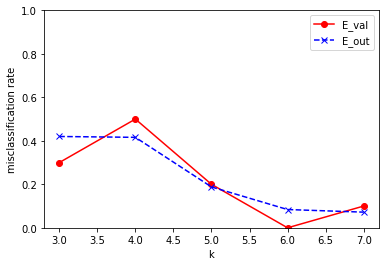

In [79]:
plt.plot(k_list, E_val_25, 'ro-', label='E_val')
plt.plot(k_list, E_out_25, 'bx--', label='E_out')
plt.legend()
plt.ylim([0, 1])
plt.xlabel('k')
plt.ylabel('misclassification rate')

#### 3) D_train = 10, D_val = 25 => evaluate on D_val

In [75]:
E_val_10 = []

for k in k_list:
    m = MyLinReg().fit(Z_val[:, :k+1], y_val)
    E_val_10.append(m.classification_error(Z_train[:, :k+1], y_train))

In [76]:
pd.DataFrame({'k':k_list, 'E_val': E_val_10})

,E_val,k
0,0.28,3
1,0.36,4
2,0.20,5
3,0.08,6
4,0.12,7


#### 4) D_train = 10, D_val = 25 => evaluate on D_out

In [80]:
E_out_10 = []
for k in k_list:
    m = MyLinReg().fit(Z_val[:, :k+1], y_val)
    E_out_10.append(m.classification_error(Z_out[:, :k+1], y_out))
    
pd.DataFrame({'k': k_list, 'E_out': E_out_10})

,E_out,k
0,0.396,3
1,0.388,4
2,0.284,5
3,0.192,6
4,0.196,7


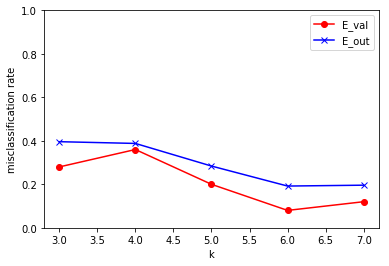

In [81]:
plt.plot(k_list, E_val_10, 'ro-', label='E_val')
plt.plot(k_list, E_out_10, 'bx-', label='E_out')
plt.ylim([0, 1])
plt.legend()
plt.xlabel('k')
plt.ylabel('misclassification rate')


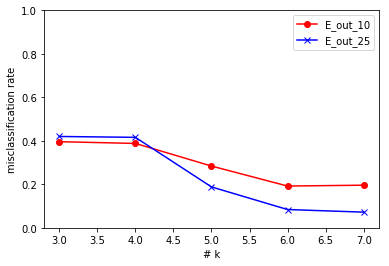

In [86]:
plt.plot(k_list, E_out_10, 'ro-', label='E_out_10')
plt.plot(k_list, E_out_25, 'bx-', label='E_out_25')
plt.ylim([0, 1])
plt.xlabel('# k')
plt.ylabel('misclassification rate')
plt.legend()
plt.show()

### Validation Bias

In [93]:
n_var = 2
n_trial = 1000000

trial = np.random.uniform(low=0, high=1, size=(n_trial, n_var))

In [94]:
e1_mean, e2_mean = trial.mean(axis=0)
e1_mean, e2_mean

(0.49997459092886659, 0.50014572865242146)

In [95]:
e = np.min(trial, axis=1)
e.mean()

0.33333272798475949

### Cross Validation

In [110]:
def get_slope_bias(p1, p2):
    '''return a, b for equation y = mx + b
    from two given points'''
    x1, y1 = p1
    x2, y2 = p2
    m = (y2 - y1)/(x2 - x1)
    b = y1 - m*x1
    return m, b

def pred_y(m, b, p):
    x, y = p
    y_hat = m*x + b
    return y_hat

def square_error(p1, p2, p_val):
    m, b = get_slope_bias(p1, p2)
    y_hat = pred_y(m, b, p_val)
    _, y = p_val
    return (y - y_hat)**2

In [97]:
import sympy as sp

In [99]:
p = sp.symbols('p')

In [101]:
expr = 1/(1+p)**2 + 1/(1-p)**2 - 1

In [102]:
sp.solve(expr)

[-I*sqrt(-2 + sqrt(5)),
 I*sqrt(-2 + sqrt(5)),
 -sqrt(2 + sqrt(5)),
 sqrt(2 + sqrt(5))]

In [112]:
x1 = [-1, 0]
x2 = [1, 0]
x3 = [p, 1]

In [114]:
expr = square_error(x1, x2, x3) + square_error(x1, x3, x2) + square_error(x3, x2, x1)

In [115]:
sp.solve(expr - 1.5)

[-4.33566130724400,
 4.33566130724400,
 -0.893285492512171*I,
 0.893285492512171*I]

In [116]:
4.33

4.33

In [117]:
np.sqrt(np.sqrt(3)+4)

2.3941701709713277

In [118]:
np.sqrt(np.sqrt(3)-1)

0.85559967716735208

In [119]:
np.sqrt(9 + 4*np.sqrt(6))

4.3356613072439956

In [120]:
np.sqrt(9 - np.sqrt(6))

2.5593964634688433

### PLA vs. SVM

In [129]:
class TargetFunc:
    
    def __init__(self, p1, p2):
        self.w = self._get_line(p1, p2)
        
    def _get_line(self, p1, p2):
        
        x1, y1 = p1
        x2, y2 = p2
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m*x1
        return np.array([b, m, -1.])
    
    def __call__(self, X):
        X = np.c_[np.ones(len(X)), X]
        return np.sign(np.dot(X, self.w))

In [161]:
class PLA:
    '''Perceptron Learning Algorithm'''
    
    def fit(self, X, y):
        X = np.c_[np.ones(len(X)), X]
        self.w_ = np.zeros(X.shape[1])
        
        y_pred = self.predict(X)
        while self.error_count(y, y_pred):
            idx_wrong = (y_pred != y)
            x_n, y_n = self._get_rand_Xy(X[idx_wrong], y[idx_wrong])
            self.w_ += y_n*x_n
            y_pred = self.predict(X)
        return self
    
    def predict(self, X):
        if X.shape[1]  != len(self.w_):
            X = np.c_[np.ones(len(X)), X]
        return np.sign(np.dot(X, self.w_))
    
    def error_count(self, y_true, y_pred):
        return (y_true != y_pred).sum()
    
    def _get_rand_Xy(self, X, y):
        i = np.random.randint(len(X))
        return X[i], y[i]
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return (y != y_pred).mean()

In [229]:
class SVM:
    
    def fit(self, X, y):
        from cvxopt import matrix, solvers
        solvers.options['show_progress'] = False
        
        Q = np.dot(y[:, np.newaxis]*X, y[np.newaxis, :]*X.T)
        p = -np.ones(len(X))
        A = np.vstack([y, -y, np.identity(len(X))])
        c = np.zeros(len(A))
        
        alphas = solvers.qp(*map(matrix, [Q, p, -A, c]), show_progress=False)['x']
        alphas = np.array(alphas).ravel()
        is_svm = (alphas > 1e-5)
        self.support_vectors = X[is_svm]
        self.n_svm = self.support_vectors.shape[0]
        y_svm = y[is_svm]
        
        self.w_ = np.dot(y_svm * alphas[is_svm], self.support_vectors)
        self.b_ = y_svm[0] - np.dot(self.w_, self.support_vectors[0])
        
        return self
        
    def predict(self, X):
        return np.sign(np.dot(X, self.w_) + self.b_)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return (y != y_pred).mean()
    


In [230]:
n_pop = 2000
n_sample_1 = 10
n_sample_2 = 100
n_dim = 2

n_run = 1000

E_out_svm10 = []
E_out_pla10 = []
E_out_svm100 = []
E_out_pla100 = []
n_svm = 0

num_svm10_win = 0
num_svm100_win = 0

for i in range(n_run):
    # init random dataset
    X_test = np.random.uniform(low=-1, high=1, size=(n_pop, n_dim))
    X_train1 = np.random.uniform(low=-1, high=1, size=(n_sample_1, n_dim))
    X_train2 = np.random.uniform(low=-1, high=1, size=(n_sample_2, n_dim))

    # create a random target function
    while True:
        p1, p2 = np.random.uniform(-1, 1, (2, n_dim))
        f = TargetFunc(p1, p2)

        y = f(X_train1)

        if (y==1).sum() and (y==-1).sum():
            break

    y_train1 = f(X_train1)
    y_train2 = f(X_train2)
    y_test = f(X_test)

    pla10 = PLA().fit(X_train1, y_train1)
    svm10 = SVM().fit(X_train1, y_train1)

    pla100 = PLA().fit(X_train2, y_train2)
    svm100 = SVM().fit(X_train2, y_train2)

    e_svm10 = svm10.score(X_test, y_test)
    e_pla10 = pla10.score(X_test, y_test)
    e_svm100 = svm100.score(X_test, y_test)
    e_pla100 = pla100.score(X_test, y_test)
    
    n_svm += svm100.n_svm
    
    E_out_pla10.append(e_pla10)
    E_out_svm10.append(e_svm10)
    E_out_pla100.append(e_pla100)
    E_out_svm100.append(e_svm100)
    
    if e_svm10 < e_pla10:
        num_svm10_win += 1
    if e_svm100 < e_pla100:
        num_svm100_win += 1

print('% svm10: {}'.format(num_svm10_win / n_run))
print('% svm100: {}'.format(num_svm100_win / n_run))
print('avg # svm: {}'.format(n_svm / n_run))

% svm10: 0.617
% svm100: 0.62
avg # svm: 3.086


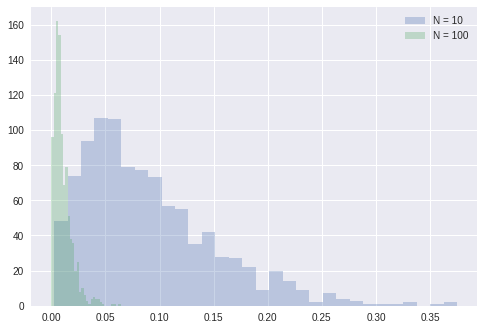

In [232]:
plt.hist(E_out_svm10, bins=30, alpha=.3, label='N = 10')
plt.hist(E_out_svm100, bins=30, alpha=.3, label='N = 100')
plt.legend()

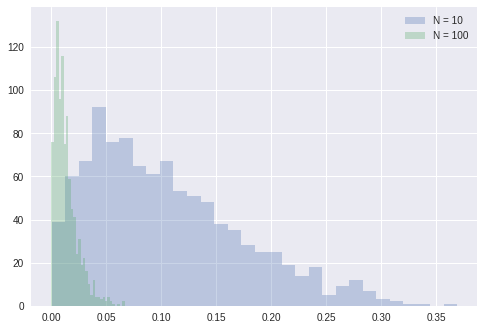

In [233]:
plt.hist(E_out_pla10, bins=30, alpha=.3, label='N = 10')
plt.hist(E_out_pla100, bins=30, alpha=.3, label='N = 100')
plt.legend()